# pHunt LLR - the _PromoterHunter_

Inspired by [PromoterHunter](http://www.phisite.org/main/index.php?nav=tools&nav_sel=hunter) tool.

The algorithm differs from the original pHunt because:
1. PSSM-scores are not normalized
2. The final score is not a linear combination of three independent scores, but a single Log-Likelihood Ratio (LLR)
3. No rolling average is applied to the ΔG values in the pre-processing phase
4. It processes only the forward strand

## GibbsFE

This function implements the computation of the Gibbs Free Energy of a DNA sequence. It does so by using a look-up-table for dinucleotide contributions to the Gibbs FE. The idea behind the computation of Gibbs FE for promoter prediction is that _"Regions with lower ΔG values are thermodynamically less stable. Prokaryotic promoters are usually localized in these regions."_

In [1]:
# Imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import motifs
from Bio.SeqUtils import GC as gc
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Define GibbsFE function
"""
GibbsFE: computes the Gibbs Free Energy of a DNA sequence
reads in:
- DNA sequence (BioPython Seq object)
- window length (to compute Free Energy over)
Assumes the DNA sequence only contains DNA characters (A, C, G, T)
"""
def GibbsFE(mySeq, wlen=None):
    mySeq = mySeq.upper()   #upper case sequence
    
    #define Gibbs Free Energy sequence components
    LUTfe = {
            'AA' : 4.18,
            'AC' : 6.02,
            'AG' : 5.36,
            'AT' : 3.68,
            'CA' : 6.07,
            'CC' : 7.70,
            'CG' : 9.08,
            'CT' : 5.36,
            'GA' : 5.44,
            'GC' : 9.37,
            'GG' : 7.70,
            'GT' : 6.02,
            'TA' : 2.43,
            'TC' : 5.44,
            'TG' : 6.07,
            'TT' : 4.18      
            }

    #convert sequence to vector
    myVec = []
    #return empty vector if sequence is less than 2 nucleotides
    mySeqlen = len(mySeq)
    if mySeqlen<2:
        return(myVec)
    #iterate over the sequence, grabbing two elements at time
    #with a +1 step size
    for p in range(mySeqlen-1):
        dinuc = mySeq[p]+mySeq[p+1]  #create dinucleotide
        myVec.append(LUTfe[dinuc])   #look up GE value in table
    
    #perform moving average, if requested (wlen!=None)
    if (wlen):
        myVeclen = len(myVec)
        #return original vector if window size over length
        if myVeclen<wlen:
            return(myVec)
        myMAvec = []
        for p in range(myVeclen-wlen+1):
            #compute average
            myMAvec.append(sum(myVec[p:p+wlen])/wlen)
        #return moving average vector
        return(myMAvec)
    else:
        return(myVec)


### Usage example

The GibbsFE function is applied to a sequence from E. coli, and the energy profile is displayed.

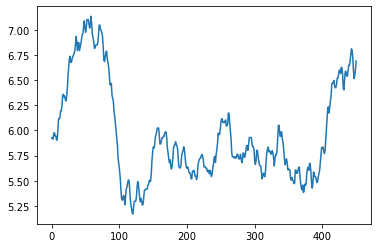

In [3]:
#create a sequence record
mydna = SeqRecord(Seq('GTCAGGTGATTGACGAAGATGTCTATCCGATTCTGTCGCTGCAATCGTGCCTCGACAAGCGTGCGGCAAAAGGCGGCGTCTCACCGCAGCAGGTGGCGCAGGCGATTGCTTTTGCGCAGGCTCGGTTAGGGTAAGAACATTTATATGTATAAATTTGAGCCTGGCTTATCGCCGGGCTTTTTTATGGCAAAAAAAAGCGGATCCTGGAGATCCGCAAAAGTTCACGTTGGCTTTAGTTATTCGAGTTGAGAAACTCTCGAAACGGGCAGTGACTTCAAGGGTTAAAAGAGGTGCCGCTCCGTTTCTGTGAGCAATTATCAGTCAGAATGCTTGATAGGGAGCGCCGTTCATTGCTATTCTACCTATCGCCATGAACTATCGTGGCGATGGAGGATGGATAATGAATATTCGTGATCTTGAGTACCTGGTGGCATTGGCTGAACACCGCCATTTTCGGCGTGCGGCAGATTCCTGCCACGTTAGCCAGCCGACGCTTAGCGG'),\
                        id='NC_000913.3:4158090-4158590',\
                        description='PoxyR_Ecoli')    

#call GibbsFE function
energies = GibbsFE(mydna,50)

#plot results
plt.plot(energies)

## Energy distribution estimation

Use a reference set [PromEC](http://margalit.huji.ac.il/promec/index.html) to estimate the distribution of Gibbs Free Energy values over known promoter sequences. 

Use the _E. coli_ genome to estimate the distribution of GFE values over (mostly) non-promoter sequences.

In [4]:
#open reference set to estimate energy distribution
#process all sequences in reference set
pos_ener = []   #list of average energies

for aseq in SeqIO.parse('PromEC/PromEC_seqs_filtered.fas','fasta'):
    es = GibbsFE(aseq, 0)   #get list of energies
    pos_ener.append(sum(es)/len(es))   #story average energy for the sequence


# define window size
wsize=len(aseq)
'''
For general applications of this program, the definition of wsize will
require some discussion.
'''

neg_ener = []   #list of average energies
#open genome to estimate background energy distribution
with open('PromEC/NC_000913.3.fasta', 'r') as f:
     neg_seq = SeqIO.read(f,'fasta')

for p in range(0,len(neg_seq)-wsize+1,25):
    es = GibbsFE(neg_seq[p:p+wsize], 0)
    neg_ener.append(sum(es)/len(es))   #store average energy for the window


<BarContainer object of 30 artists>

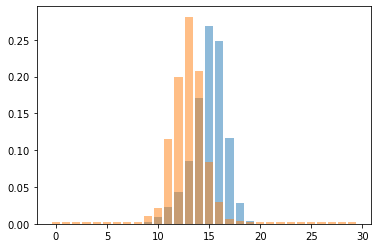

In [5]:
# Frequency distributions (on positive and negative set)
# Defining the frequency distributions for the positive and the
# negative sets requires binning.

# Set number of bins
n_bins = 30

# Set pseudocount values
pc = 1

# Energy frequencies for the negative set
hist_neg, bin_edges = np.histogram(neg_ener, range=(2.43 , 9.37), density=False, bins=n_bins)
hist_neg = (hist_neg+pc)/(hist_neg+pc).sum()

# Energy frequencies for the positive set
hist_pos, bin_edges = np.histogram(pos_ener, range=(2.43 , 9.37), density=False, bins=n_bins)
hist_pos = (hist_pos+pc)/(hist_pos+pc).sum()

# Plot frequency distributions as histograms
plt.bar(range(n_bins), hist_neg, alpha=0.5)
plt.bar(range(n_bins), hist_pos, alpha=0.5)


## Promoter assessment

This function implements the assessment of putative promoter sequences in a DNA sequence. It looks only at the forward strand. The function receives a sequence, two instantiated BioPython motif objects and a min/max spacer distance. It calls the GibbsFE function to obtain a vector of Gibbs Free Energy dinucleotide contributions. It will then return a list of the (5 default) best putative promoters, along with their score.

In [6]:

"""Predicts putative promoters in a given sequence, following the PromoterHunter approach.
   Inputs:
   - mySeq - DNA sequence [Seq, not SeqRecord object]
   - lmot - -35 motif object
   - lthrs - score threshold for -35 motif
   - rmot - -10 motif object
   - rthrs - score threshold for -10 motif
   - [minD, maxD] - range of spacer lengths
   - wsize - size of moving average window for Gibbs free energy
   - [lerg,rerg] - range surrounding -10 on which to compute energy score
   
   Returns:
   - List of High-scoring Motif Pairs (HSMP), with all the score and sequence information
     for the constituent motifs and energy
"""
def pHunt(mySeq, lmot, lthrs, rmot, rthrs, minD, maxD, wsize, posdist, negdist, binedges):
    lerg=-wsize//2   #left window from -10 for energy
    rerg=+wsize//2    #right window from -10 for energy
    GC = gc(mySeq)/100
    #score sequence with left motif
    lscrs=lmot.pssm.calculate(mySeq).tolist()
    #score sequence with left motif
    rscrs=rmot.pssm.calculate(mySeq).tolist()
    #compute the Gibbs Free Energy vector
    fes = GibbsFE(mySeq, None)
    
    #list of spacer-adequate high-scoring motif pairs
    hsmp = []
    
    mySeqlen = len(mySeq)
    #go through sequence, first with left PSSM
    for pl in range(mySeqlen-(lmot.pssm.length + minD + rmot.pssm.length)):
        #if score above threshold
        if lscrs[pl] > lthrs:
            remrange = pl+lmot.pssm.length+maxD+1 if (pl+lmot.pssm.length+maxD+1 < mySeqlen - rmot.pssm.length) else mySeqlen - rmot.pssm.length
            #go through sequence, now with right PSSM, up to spacer
            for pr in range(pl+lmot.pssm.length+minD,remrange):
                #if score above threshold
                if rscrs[pr] > rthrs:
                    element = {'lpos' : pl, 'lseq' : str(mySeq[pl:pl+lmot.pssm.length]),
                               'lscr' : lscrs[pl],
                               'rpos' : pr, 'rseq' : str(mySeq[pr:pr+rmot.pssm.length]),
                               'rscr' : rscrs[pr],
                               'spcr' : str(mySeq[pl+lmot.pssm.length:pr].lower()),
                              }
                    #compute overall (normalized) PSSM contribution
                    element['mscr'] = element['lscr'] + element['rscr']

                    #add Gibbs Free Energy component
                    #as average betweeen coordinates (plus lerg, rerg margins)
                    lrange = pr+lerg if pr+lerg>0 else 0
                    rrange = pr+rerg if pr+rerg<mySeqlen-rmot.pssm.length else mySeqlen-rmot.pssm.length
                    element['escr'] = sum(fes[lrange:rrange])/(rrange-lrange)
                    
                    p_pos = posdist[np.where(binedges>element['escr'])[0][0] - 1]
                    p_neg = negdist[np.where(binedges>element['escr'])[0][0] - 1]
                    
                    element['ellr'] = np.log2(p_pos / p_neg)
                    
                    #compute final score (global norm motif score + 2*norm energy score)
                    element['Fscr'] = element['mscr'] + element['ellr']
                    
                    #add high-scoring motif pair with all info to the list of HSMPs
                    hsmp.append(element)
                  
    #return list of spacer-adequate high-scoring motif pairs
    return(hsmp)


### Usage example 1

The pHunt function is applied to look for a promote in a sequence from E. coli,
using two PSSMs (for the -35 and the -10) and a range of possible spacer lengths
between the two PSSMs.
The two PSSMs come from **Djordjevic 2011 J. Bact E. coli collections**.


In [7]:
#create a sequence record
mydna = SeqRecord(Seq('GTCAGGTGATTGACGAAGATGTCTATCCGATTCTGTCGCTGCAATCGTGCCTCGACAAGCGTGCGGCAAAAGGCGGCGTCTCACCGCAGCAGGTGGCGCAGGCGATTGCTTTTGCGCAGGCTCGGTTAGGGTAAGAACATTTATATGTATAAATTTGAGCCTGGCTTATCGCCGGGCTTTTTTATGGCAAAAAAAAGCGGATCCTGGAGATCCGCAAAAGTTCACGTTGGCTTTAGTTATTCGAGTTGAGAAACTCTCGAAACGGGCAGTGACTTCAAGGGTTAAAAGAGGTGCCGCTCCGTTTCTGTGAGCAATTATCAGTCAGAATGCTTGATAGGGATAATCGTTCATTGCTATTCTACCTATCGCCATGAACTATCGTGGCGATGGAGGATGGATAATGAATATTCGTGATCTTGAGTACCTGGTGGCATTGGCTGAACACCGCCATTTTCGGCGTGCGGCAGATTCCTGCCACGTTAGCCAGCCGACGCTTAGCGG'),\
                        id='NC_000913.3:4158090-4158590',\
                        description='PoxyR_Ecoli')    

#read in motif 1 instances, create motif and define threshold
motif_seqs = SeqIO.parse('Eco-35.fas','fasta')
motif_instances = [s.seq for s in motif_seqs]
m1 = motifs.create(motif_instances, 'ACGT')
m1._pseudocounts = 0.05
t1 = m1.pssm.distribution(precision=10**3).threshold_patser()

#read in motif 2 instances, create motif and define threshold
motif_seqs = SeqIO.parse('Eco-10.fas','fasta')
motif_instances = [s.seq for s in motif_seqs]
m2 = motifs.create(motif_instances, 'ACGT')
m2._pseudocounts = 0.05
t2 = m2.pssm.distribution(precision=10**3).threshold_patser()


print('\nUsing Djordjevic 2011 J. Bact E. coli collections')
print(m1.consensus)
print('Thres:',t1)
print(m2.consensus)
print('Thres:',t2)
print('')

# minimum and maximum spacer length
min_sl = 15
max_sl = 18

# call pHunt finction to predict promoters
mypromoters = pHunt(mydna.seq, m1, t1, m2, t2, min_sl, max_sl, wsize, hist_pos, hist_neg, bin_edges)

#sort results by global score
mypromoters = sorted(mypromoters, key = lambda k: k['Fscr'], reverse=True)

for promoter in mypromoters:
    print('Range:', promoter['lpos'],'-',promoter['rpos'], '|', promoter['rpos']-promoter['lpos']-6, \
          '- L:',round(promoter['lscr'],2),'R:',round(promoter['rscr'],2),\
          'FE:',round(promoter['escr'],2), 'FELLR:',round(promoter['ellr'],2), 'T:',round(promoter['Fscr'],2),\
         '- S:',promoter['lseq']+promoter['spcr']+promoter['rseq'])



Using Djordjevic 2011 J. Bact E. coli collections
TTGACA
Thres: 0.03828859126248574
TATAAT
Thres: 1.9188231130852493

Range: 330 - 354 | 18 - L: 4.61 R: 5.47 FE: 5.44 FELLR: 1.73 T: 11.81 - S: TTGATAgggataatcgttcattgcTATTCT
Range: 314 - 338 | 18 - L: 4.11 R: 5.22 FE: 5.68 FELLR: 0.28 T: 9.61 - S: TTATCAgtcagaatgcttgataggGATAAT
Range: 375 - 396 | 15 - L: 1.01 R: 5.22 FE: 5.65 FELLR: 1.73 T: 7.95 - S: CTATCGtggcgatggaggatgGATAAT
Range: 226 - 249 | 17 - L: 4.02 R: 3.31 FE: 5.84 FELLR: 0.28 T: 7.61 - S: TTGGCTttagttattcgagttgaGAAACT
Range: 301 - 322 | 15 - L: 1.12 R: 4.48 FE: 5.55 FELLR: 1.73 T: 7.33 - S: TTTCTGtgagcaattatcagtCAGAAT
Range: 125 - 149 | 18 - L: 0.6 R: 5.66 FE: 5.73 FELLR: 0.28 T: 6.55 - S: TTAGGGtaagaacatttatatgtaTAAATT
Range: 355 - 376 | 15 - L: 0.37 R: 3.8 FE: 5.41 FELLR: 2.23 T: 6.39 - S: ATTCTAcctatcgccatgaacTATCGT
Range: 125 - 147 | 16 - L: 0.6 R: 3.61 FE: 5.74 FELLR: 0.28 T: 4.49 - S: TTAGGGtaagaacatttatatgTATAAA
Range: 380 - 402 | 16 - L: 0.37 R: 2.81 FE: 5.71 FELLR:

### Usage example 2

The pHunt function is applied to look for a promote in a sequence from E. coli,
using two PSSMs (for the -35 and the -10) and a range of possible spacer lengths
between the two PSSMs.
The two PSSMs are the **default matrices from PromoterHunter**.


In [9]:
#read in motif 1 JASPAR file, create motif and define threshold
with open("Eco-35.jaspar") as handle:
    m1 = motifs.parse(handle, 'jaspar')[0]
m1._pseudocounts = 0.05
t1 = m1.pssm.distribution(precision=10**3).threshold_patser()
#read in motif 2 JASPAR file, create motif and define threshold
with open("Eco-10.jaspar") as handle:
    m2 = motifs.parse(handle, 'jaspar')[0]
m2._pseudocounts = 0.05
t2 = m2.pssm.distribution(precision=10**3).threshold_patser()

print('\nUsing PromoterHunter default matrices')
print(m1.consensus)
print('Thres:',t1)
print(m2.consensus)
print('Thres:',t2)
print('')

# call pHunt finction to predict promoters
mypromoters = pHunt(mydna.seq, m1, t1, m2, t2, min_sl, max_sl, wsize, hist_pos, hist_neg, bin_edges)

#sort results by global score
mypromoters = sorted(mypromoters, key = lambda k: k['Fscr'], reverse=True)

for promoter in mypromoters:
    print('Range:', promoter['lpos'],'-',promoter['rpos'], '|', promoter['rpos']-promoter['lpos']-6, \
          '- L:',round(promoter['lscr'],2),'R:',round(promoter['rscr'],2),\
          'FE:',round(promoter['escr'],2), 'FELLR:',round(promoter['ellr'],2), 'T:',round(promoter['Fscr'],2),\
         '- S:',promoter['lseq']+promoter['spcr']+promoter['rseq'])


Using PromoterHunter default matrices
TTGACA
Thres: 0.20060658881399718
TATAAT
Thres: 1.0611048434764747

Range: 330 - 354 | 18 - L: 6.06 R: 4.83 FE: 5.44 FELLR: 1.73 T: 12.62 - S: TTGATAgggataatcgttcattgcTATTCT
Range: 314 - 338 | 18 - L: 3.25 R: 5.4 FE: 5.68 FELLR: 0.28 T: 8.93 - S: TTATCAgtcagaatgcttgataggGATAAT
Range: 350 - 371 | 15 - L: 4.34 R: 1.53 FE: 5.41 FELLR: 2.23 T: 8.09 - S: TTGCTAttctacctatcgccaTGAACT
Range: 154 - 177 | 17 - L: 3.18 R: 1.76 FE: 5.52 FELLR: 1.73 T: 6.67 - S: TTGAGCctggcttatcgccgggcTTTTTT
Range: 301 - 322 | 15 - L: 0.83 R: 3.62 FE: 5.55 FELLR: 1.73 T: 6.18 - S: TTTCTGtgagcaattatcagtCAGAAT
Range: 226 - 249 | 17 - L: 3.8 R: 1.92 FE: 5.84 FELLR: 0.28 T: 6.0 - S: TTGGCTttagttattcgagttgaGAAACT
Range: 290 - 312 | 16 - L: 1.54 R: 2.39 FE: 5.65 FELLR: 1.73 T: 5.65 - S: GTGCCGctccgtttctgtgagcAATTAT
Range: 365 - 389 | 18 - L: 2.6 R: 1.18 FE: 5.55 FELLR: 1.73 T: 5.51 - S: TCGCCAtgaactatcgtggcgatgGAGGAT
Range: 178 - 199 | 15 - L: 2.49 R: 1.69 FE: 5.68 FELLR: 0.28 T: 4.